# Cross Validation & Ensembling

In [1]:
from IPython.display import Image
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

* We will guide you through the **cross validation** technique for **hyperparameter selection**. 
* We will also practice the **ensemble learning techniques** that combine multiple base-leaners for better performance.

# <a name='BackHM'>Holdout Method</a>
* More information about [Holdout Method](#HM).
* We hold out the validation and testing sets for hyperparameter tuning and performance reporting. 
* Specifically, we partition a dataset X into the **training, validation, and testing sets**.
* We use the training set to fit a model by giving a set of hyperparameters, and then use the validation set to evaluate the performance of the model given the hyperparameters.
* We repeat these two steps by issuing different sets of hyperparameters and pick the set that leads to the highest validation performance.
* We then use both the training and validation sets to train our final model, and apply it the testing set to evaluate/report the generalization performance.
<img src='https://nthu-datalab.github.io/ml/labs/08_CV_Ensembling/fig-holdout.png' width='400'></img>
* Next, we apply this technique to evaluate the KNeighborsClassifier on the Iris dataset. For simplicity, we consider the sepal width and petal length features only. Let's split the dataset first:

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# hold out validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

* We iterate through each value of hyperparameter n_neighbors = 1, 15, 50 to train on the training set and estimate performance on the validation set and record the best:

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]: 
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
    if score > best_score:
        best_k, best_score = k, score
    clfs[k] = pipe
    
# performance reporting
y_pred= clfs[best_k].predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' % 
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.9375
[15-NN]
Validation accuracy: 0.90625
[50-NN]
Validation accuracy: 0.4375

Test accuracy: 0.89 (n_neighbors=1 selected by the holdout method)


* One major disadvantage of the holdout method is that the validation and testing performance is **sensitive to the random splits**. If we have a unfortunate split such that the validation (resp. testing) set is unrepresentative, we may end up picking suboptimal hyperparameters (resp. reporting a misleading performance score).
* In this case, the hyperparameter n_neighbors = 15 actually leads to better test performance:

In [4]:
y_pred= clfs[15].predict(X_test)
print('Test accuracy: %.2f (n_neighbors=15 selected manually)' % 
      accuracy_score(y_test, y_pred))

Test accuracy: 0.91 (n_neighbors=15 selected manually)


* We can see that the validation set is unrepresentative and leads to indistinguishable validation accuracy scores (1.0) for all values of n_neighbors.
* Next, we take a look at a more robust technique called the K-Fold Cross-Validation.

# K-Fold Cross Validation
* In K-fold cross-validation (CV), we **randomly** split the training dataset into K folds without replacement, where K−1 folds are used for the model training and the remaining 1 fold is for testing. 
* This procedure is repeated K times so that we obtain K models and K performance estimates.
* Then we take their average as the final performance estimate. The following figure illustrate the 10-fold CV:
<img src='https://nthu-datalab.github.io/ml/labs/08_CV_Ensembling/fig-kfold.png' width='500'>
* We can apply K-fold CV to either the hyperparameter tuning, performance reporting, or both. 
* **The advantage of this approach is that the performance is less sensitive to unfortunate splits of data**.
* In addition, it utilize data better since each example can be used for both training and validation/testing.
* Let's use K-Fold CV to select the hyperparamter n_neighbors of the KNeighborsClassifier:

In [5]:
from sklearn.model_selection import cross_val_score

iris = load_iris()
X, y = iris.data[:,[1,2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

* The dataset is first split into training/testing sets.

In [6]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]: # experiment different hyperparameter
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=k)]])
    pipe.fit(X_train, y_train)
    # K-Fold CV
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
    if scores.mean() > best_score:
        best_k, best_score = k, scores.mean()
    clfs[k] = pipe

[1-NN]
Validation accuracy: 0.894 [0.91304348 0.95454545 0.85       0.85       0.9       ]
[15-NN]
Validation accuracy: 0.914 [0.95652174 0.86363636 0.85       0.9        1.        ]
[50-NN]
Validation accuracy: 0.801 [0.73913043 0.86363636 0.75       0.75       0.9       ]


* 5-fold CV selects the best n_neighbors = 15 as we expected. Once selecting proper hyperparameter values, we retrain the model on the complete training set and obtain a final performance estimate on the test set:

In [7]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' % 
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.93 (n_neighbors=15 selected by 5-fold CV)


# Nested CV
* We can also apply the K-fold CV to both the hyperparameter selection and performance reporting at the same time, this is called the nested CV. Following illustrate the 5×2 nested CV:
<img src='https://nthu-datalab.github.io/ml/labs/08_CV_Ensembling/fig-nestedcv.png' width='500'>
* where we select the values of hyperparameters by 2-fold CV and estimate the generalized performance by 5-fold CV, respectively. Let's try this ourselves:

In [8]:
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [1, 15, 50]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
            X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
            y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


* The 5 inner CVs may select different values for the hyperparameter n_neighbors. In this case, the 1st inner CV selects n_neighbors = 1 due to a unlucky split of the training and testing sets in the outer fold. By doing nested CV, we get a more robust performance estimate.
* In fact, we can simplify the above example using the GridSearchCV from Scikit-learn:

In [9]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 15, 50]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


* NOTE: 
    * if we have a dataset with imbalance classes, we should use the stratified K-fold CV that prepserves the class proportions in each fold to ensure that each fold is representative of the class proportions in the training dataset. To use stratified CV, simply replace
        * from sklearn.model_selection import KFold
        * KFold(n_splits=...)
    * with 
        * from sklearn.model_selection import StratifiedKFold
        * StratifiedKFold(y=..., n_splits=...)

### How Many Folds?
* How many folds K do we need? 
    * Here are some rules of thumb explained in the lecture:
        * For large K, the MSE of cross-validation error (to the true expected generalization error of fN) tends to have a small bias but large variance since a classifier in each iteration is trained on more examples but classifiers from different folds are trained on similar examples;
        * On the other hand, for small K, the cross-validation error tends to have large bias but small variance;
        * When dataset is small, the cross-validation error will have both large bias and large variance.
* To see these in practice, let's consider the Polynomial regression where the ground truth data generating distribution is known:
$$P(y|x)=sin(x)+ϵ,ϵ∼N(0,σ2)$$
* We can visualize the bias and variance as follows:

In [10]:
def gen_data(num_data, sigma):
    x = 2 * np.pi * (np.random.rand(num_data) - 0.5)
    y = np.sin(x) + np.random.normal(0, sigma, num_data)
    return (x, y)

In [11]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sigma = 1
n_range = range(10, 50, 2)
k_range = [5, 10]

poly = PolynomialFeatures(degree=2)
X = np.array([])
y = np.array([])
cv5_mean = []
cv5_std = []
cv10_mean = []
cv10_std = []
exp_mean = []
for n in n_range:
    # compute the bias and variance of cv5
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv5 = KFold(n_splits=5, random_state=1)
        for i, (train, test) in enumerate(cv5.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv5_mean.append(np.mean(mse_test))
    cv5_std.append(np.std(mse_test))
    
    # compute the bias and variance of cv10
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        
        cv10 = KFold(n_splits=10, random_state=1)
        for i, (train, test) in enumerate(cv10.split(X, y)):
            lr = LinearRegression()
            lr.fit(X[train], y[train])
            y_test_pred = lr.predict(X[test])
            mse_test.append(mean_squared_error(y[test], y_test_pred))
    
    cv10_mean.append(np.mean(mse_test))
    cv10_std.append(np.std(mse_test))
    
    # compute the expected generalization error of f_N
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        lr = LinearRegression()
        lr.fit(X, y)
        x_test, y_test = gen_data(100, sigma)
        X_test = poly.transform(x_test[:, np.newaxis])
        y_test_pred = lr.predict(X_test)
        mse_test.append(mean_squared_error(y_test, y_test_pred))
    exp_mean.append(np.mean(mse_test))

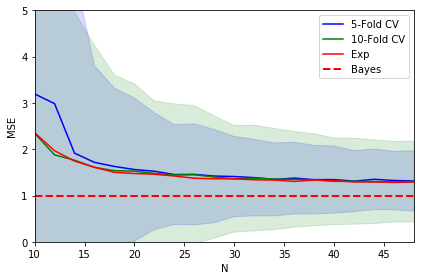

In [12]:
plt.plot(n_range, cv5_mean, 
         markersize=5, label='5-Fold CV', color='blue')
plt.fill_between(n_range,
                 np.add(cv5_mean, cv5_std),
                 np.subtract(cv5_mean, cv5_std),
                 alpha=0.15, color='blue')

plt.plot(n_range, cv10_mean, 
         markersize=5, label='10-Fold CV', color='green')
plt.fill_between(n_range,
                 np.add(cv10_mean, cv10_std),
                 np.subtract(cv10_mean, cv10_std),
                 alpha=0.15, color='green')

plt.plot(n_range, exp_mean, 
         markersize=5, label='Exp', color='red')

plt.hlines(y=sigma, xmin=10, xmax=48, 
           label='Bayes', color='red', 
           linewidth=2, linestyle='--')

plt.legend(loc='upper right')
plt.xlim([10, 48])
plt.ylim([0, 5])
plt.xlabel('N')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('./output/fig-cv-fold.png', dpi=300)
plt.show()

* Usually, we set K=10 in most applications, K=5 for larger datasets, and K=N for very small datasets. The last setting is called the leave-one-out CV.

# Ensemble Methods
* No free lunch theorem states that no machine learning algorithm is universally better than the others in all domains. 
* To goal of ensembling is to combine multiple learner to **improve the applicability and get better performance**.
* <font color='red'>NOTE:</font> 
    * it is possible that the final model performs no better than the most accurate learners in the ensemble. But it at least reduces the probability of selecting a poor one and increases the applicability.

### Voting
* Voting is arguably the most straightforward way to combine multiple learners $d(j)(⋅)$.
* The idea is to to taking a linear combination of the predictions made by the learners. For example, in multiclass classification, we have
$$\hat{y}_{k}=∑_{j}^{L}w_{j}d^{(j)}_{k}(x)$$, where$ w_{j}≥0$ and$ ∑_{j}w_{j}=1,$
 for any class k, where L is the number of voters. This can be simplified to the plurarity vote where each voter has the same weight:
$$\hat{y}_{k}=∑_{j}\frac{1}{L}d^{(j)}_{k}(x).$$
--------------------
* Let's use the VotingClassifier from Scikit-learn to combine KNeighborsClassifer, LogisticRegression, and DecisionTreeClassifier together and train on the synthetic two-moon dataset:

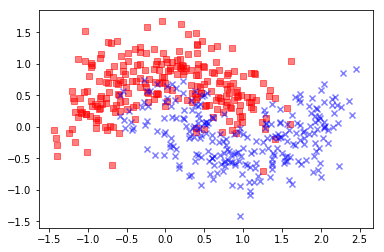

In [13]:
#import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0',
            c='r', marker='s', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1',
            c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1],
            c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])

* We can estimate the performance of individual classifiers via the 10-fold CV:

In [14]:
from sklearn.model_selection import cross_val_score

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.929 (+/- 0.029)
DecisionTree: 0.941 (+/- 0.023)
KNN: 0.948 (+/- 0.026)


* Let's combined the classifiers by VotingClassifer from Scikit-learn and experiment some weight combinations:

In [15]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)], 
                           voting='soft', weights=[a,b,c])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('%s: %.3f (+/- %.3f)' % ((a,b,c), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.959 (+/- 0.021)


/home/epl/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(0, 2, 1): 0.960 (+/- 0.019)
(1, 0, 2): 0.958 (+/- 0.023)
(1, 2, 0): 0.944 (+/- 0.025)
(2, 0, 1): 0.948 (+/- 0.023)
(2, 1, 0): 0.939 (+/- 0.025)

Best (0, 2, 1): 0.960


* The best ensemble combines the DecisionTreeClassifier and KNeighborsClassifier. This is a reasonable choice because these two models "complement" each other in design: DecisionTreeClassifier makes predictions based on informative features; while KNeighborsClassifier makes predictions based on representative examples.
* To compare the VotingClassifer with individual classifiers on the testing set, we can plot the ROC curves:

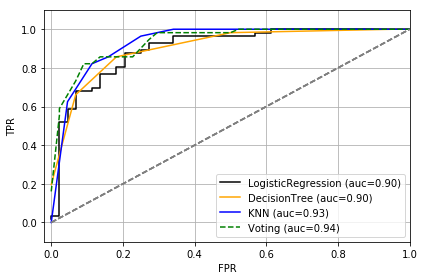

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf_labels =['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 1])
    plt.ylim([-0.1, 1.1])
    plt.grid()
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-vote-roc.png', dpi=300)
plt.show()

* As we can see, the VotingClassifer can successfully combine the base-learners to give a higher true-positive rate at a low false-positive rate. Let's see the decision boundaries:

In [17]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

'''
Parameters
    ------------
    soft : bool, optional
        Whether to plot soft regions. Default is False. Only applicable to binary classifiers.
'''
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, soft=False):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    if soft:
        Z = classifier.predict_proba(np.array([xx1.ravel(), xx2.ravel()]).T)[:, 0]
        Z = Z.reshape(xx1.shape)
        contour = plt.contourf(xx1, xx2, Z, alpha=0.4, camp=colors[0])
        plt.colorbar(contour)
    else:
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

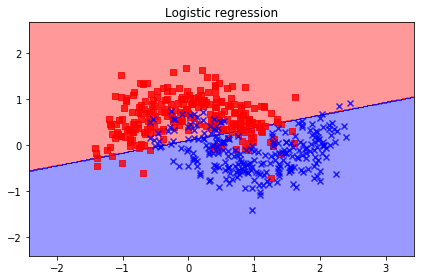

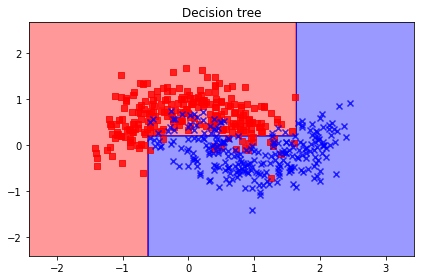

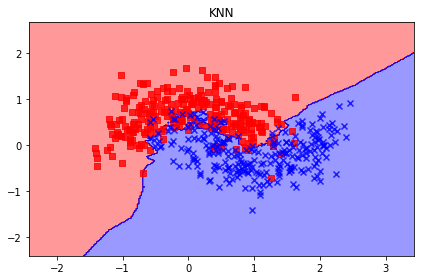

/home/epl/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


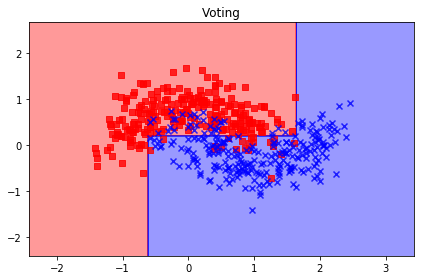

In [18]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe1,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe3,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

* The decision boundaries of DecisionTreeClassifier and VotingClassifier looks similar. But they have different soft decision boundaries that take into account the probability/confidence of predictions:

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


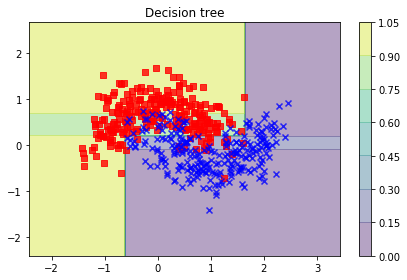

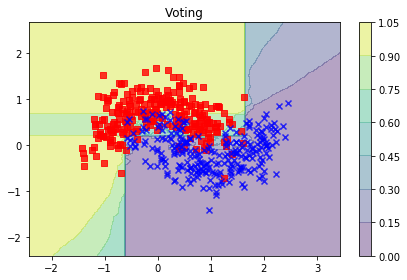

In [19]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=pipe2, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary-soft.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary-soft.png', dpi=300)
plt.show()

* The different soft decision boundaries result in different ROC curves.

### <a name='BackBagging'>Bagging</a>
* [Bagging (Bootstrap AGgragating)](#Bag) is a voting method where each base-learner are trained over a slightly different training set. The procedure of bagging is summarized below:
    1. Train L classifiers, each on a dataset generated by bootstrapping (draw with replacement);
    2. Predict by voting (aggregating all predictions of the L classifiers).
* Bagging can reduce the variance since voters now only see different training sets and become less positively correlated with each other. 
* Bagging is **more robust to noise and outliers** since we do the resampling on dataset. 
* However, the model bias cannot be reduced, and this is why we usually use classifiers with low bias, for example, decision trees or nonlinear SVMs, as the base-learners in bagging.
---------------------
* The BaggingClassifier is provided by Scikit-learn. Let's use the unpruned DecisionTreeClassifier as the base-learner and create an ensemble of 500 decision trees fitted on different bootstrap examples of the training set:

In [20]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

* The parameter max_samples controls the number of bootstrapped examples and max_feature controls the proportion of features from the feature set that will be sampled to train the base classifiers. We disable feature bootstrapping here.
* Next, we compare the performance of the trained BaggingClassifier to a single unpruned DecisionTreeClassifier:

In [21]:
from sklearn.metrics import accuracy_score

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.840
[Bagging] auc-train = 0.993, auc-test = 0.860


* We sample 0.7N examples in each bootstrap to make the base-learners more uncorrelated. 
* The BaggingClassifer successfully mitigates the overfitting behavior of the unpruned DecisionTreeClassifier and gives better generalization performance. 
* We can see this more clearly by comparing the decision boundaries of the two models:

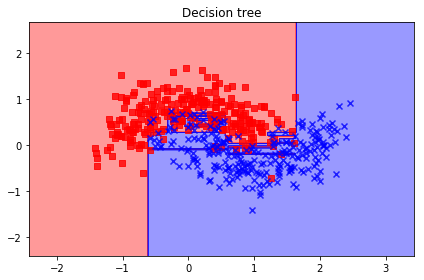

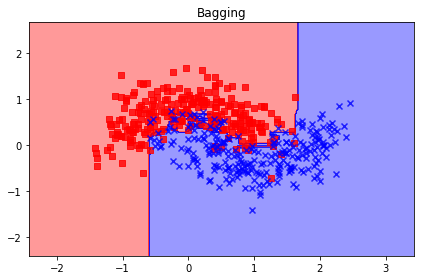

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


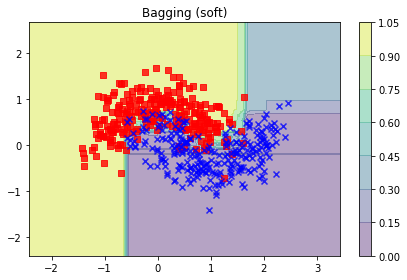

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-bagging-decision-tree-boundary.png', dpi=300)
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging (soft)')
plt.tight_layout()
plt.savefig('./output/fig-bagging-boundary-soft.png', dpi=300)
plt.show()

* The BaggingClassifer give a smoother decision boundary that less overfits the training data.

### <a name='BackBoosting'>Boosting</a>
* The key idea of **[boosting](#Boost)** is to create **complementary** base-leanrers by training the new learner using the examples that the previous leaners do not agree.
* A common implementation is **[AdaBoost](#AdaBoost)** (Adaptive Boosting), which can be summarized as followings:
    1. Initialize $Pr(i,1)=\frac{1}{N}$ for all $i$;
    2. Start from $j=1$:
        1. Randomly draw $X(j)$ from X with probabilities $Pr^{(i,j)}$ and train $d^{(j)}$
        2. Stop adding new base-learners if $\epsilon^{(j)}=\sum_{i}\Pr^{(i,j)}1(y^{(i)}\neq d^{(j)}(\boldsymbol{x}^{(i)}))\geq\frac{1}{2}$
        3. Define $αj=12log(1−ε(j)ε(j))>0$ and set $\Pr^{(i,j+1)}=\Pr^{(i,j)}\cdot\exp(-\alpha_{j}y^{(i)}d^{(j)}(\boldsymbol{x}^{(i)}))$ for all $i$
* After training, the (soft) prediction $\tilde{y}$ is made by voting:$\tilde{y}=\sum_{j}\alpha_{j}d^{(j)}(\boldsymbol{x})$

* Let's train an AdaBoostClassifier from Scikit-learn with 500 decision trees of depth 1:

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.838, accuracy-test = 0.710
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.870


* The AdaBoostClassifier predicts all training examples correctly but not so well on testing set, which is a sign of overfitting. 
* AdaBoostClassifier increases the margins of training examples (as discussed in the lecture), the variance can be controlled. Overall, AdaBoostClassifier gives better generalization performance due to a smaller bias.

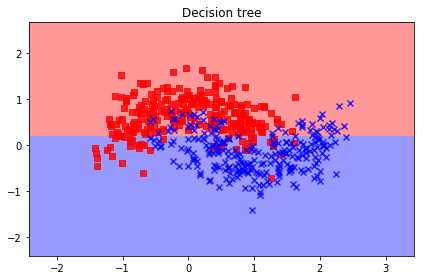

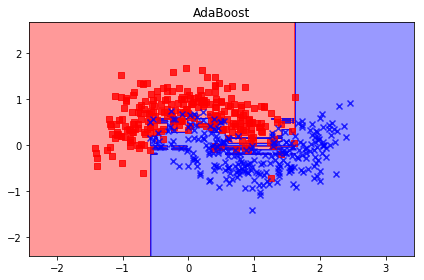

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


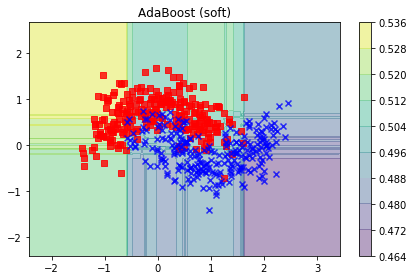

In [24]:
plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-boundary-soft.png', dpi=300)
plt.show()

* We can see that the decision boundary of AdaBoostClassifier is substantially more complex than the depth-1 decision tree.
* Next, let see how the performance AdaBoostClassifier changes as we add more weak learners:

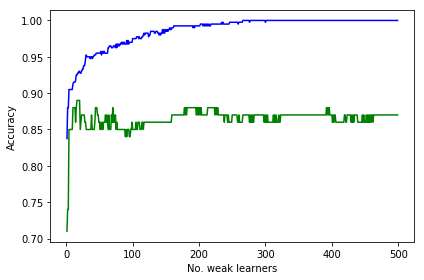

In [25]:
range_est = range(1, 500)
ada_train, ada_test = [], []
for i in range_est:
    ada = AdaBoostClassifier(base_estimator=tree, n_estimators=i, 
                             learning_rate=1, random_state=1)
    ada = ada.fit(X_train, y_train)
    y_train_pred = ada.predict(X_train)
    y_test_pred = ada.predict(X_test)

    ada_train.append(accuracy_score(y_train, y_train_pred))
    ada_test.append(accuracy_score(y_test, y_test_pred))
        
plt.plot(range_est, ada_train, color='blue')
plt.plot(range_est, ada_test, color='green')
plt.xlabel('No. weak learners')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('./output/fig-adaboost-acc.png', dpi=300)
plt.show()

* As we add more and more weak learners, the model complexity increases and the test accuracy first goes up due to the reduced bias. Then it goes down due to the increased variance.
* However, the variance does not continue to grow as we add more weak learners thanks to the enlarged margins of training examples.
* The above examples show that the AdaBoostClassifier can overfit. Also, if the dataset contains outliers or is noisy, AdaBoost will try to fit those "hard" but bad examples. We should be careful about overfitting when applying AdaBoost in practice. 
----------------------
* In this case, we can get a smoother decision boundary if we stop at L=16:

[AdaBoost16] accuracy-train = 0.925, accuracy-test = 0.890


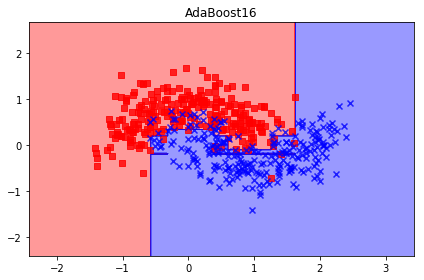

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'camp'
  s)


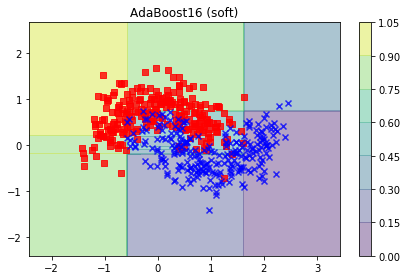

In [26]:
ada16 = AdaBoostClassifier(base_estimator=tree, n_estimators=16)
ada16.fit(X_train, y_train)
y_train_pred = ada16.predict(X_train)
y_test_pred = ada16.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost16] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary.png', dpi=300)
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada16, soft=True,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost16 (soft)')
plt.tight_layout()
plt.savefig('./output/fig-adaboost16-boundary-soft.png', dpi=300)
plt.show()

* Finally, let's compare the ROC curves of different ensemble methods:

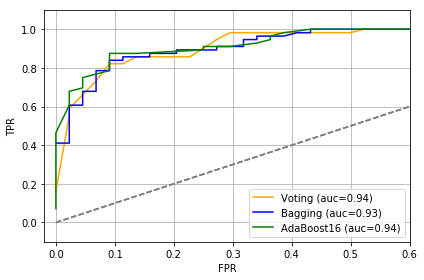

In [27]:
clf_labels =['Voting', 'Bagging', 'AdaBoost16']
colors = ['orange', 'blue', 'green']
linestyles = ['-', '-', '-']
for clf, label, clr, ls in zip([best_vt, bag, ada16], clf_labels, colors, linestyles):
    # assume positive class is at dimension 2
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([-0.02, 0.6])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-ensemble-roc.png', dpi=300)
plt.show()

# Assignment
* In this assignment, a dataset called Playground dataset will be used. This data includes four competitors and their (x, y) coordinations while they doing some exercise in the playground.
## Goal
* Train models using any methods you have learned so far to achieve best accuracy on the testing data. You can plot the train.csv and try to ensemble models that performs well on different competitors.
## Requirements
* Please keep all the models you have tried in your ipynb. 
* Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths. Try to evaluate and summarize the results. 
* The following is example code to load and plot the training data

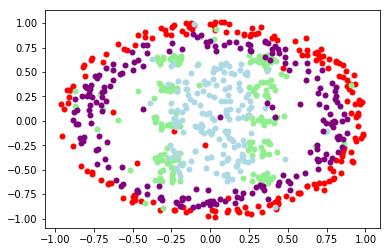

In [28]:
import csv

file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Nested cross validation
    * KNN 0.78
    * SVM 0.86
    * Random Forest 0.78

## KNN

In [30]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in range(1, 50):
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train_f, y_train_f):
            X_itrain, X_val = X_train_f[itrain_idx], X_train_f[val_idx]
            y_itrain, y_val = y_train_f[itrain_idx], y_train_f[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf', KNeighborsClassifier(n_neighbors=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.79 (n_neighbors=5 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.82 (n_neighbors=3 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.77 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.78 (5x10 nested CV)


## SVM

In [31]:
from sklearn.svm import SVC

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in range(5, 10, 15):
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train_f, y_train_f):
            X_itrain, X_val = X_train_f[itrain_idx], X_train_f[val_idx]
            y_itrain, y_val = y_train_f[itrain_idx], y_train_f[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf',SVC(kernel='rbf', random_state=0, gamma=0.2, C=k)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (C=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.86 (C=5 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.86 (C=5 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.86 (C=5 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.86 (C=5 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.86 (C=5 selected by inner 10-fold CV)

Test accuracy: 0.86 (5x10 nested CV)


## RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)): 
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    best_k, best_score = -1, -1
    clfs = {}
    # hyperparameter tuning 
    for k in [3, 5, 10, 15]:
        inner_scores = []
        # inner folds
        for itrain_idx, val_idx in inner_cv.split(X_train_f, y_train_f):
            X_itrain, X_val = X_train_f[itrain_idx], X_train_f[val_idx]
            y_itrain, y_val = y_train_f[itrain_idx], y_train_f[val_idx]
            
            pipe = Pipeline([['sc', StandardScaler()],
                             ['clf',RandomForestClassifier(max_depth=k, random_state=0)]])
            pipe.fit(X_itrain, y_itrain)
            
            y_pred = pipe.predict(X_val)
            inner_scores.append(accuracy_score(y_val, y_pred))
        score_mean = np.mean(inner_scores)
        if best_score < score_mean:
            best_k, best_score = k, score_mean
        clfs[k] = pipe
        
    # evaluate performance on test fold
    best_clf = clfs[best_k]
    best_clf.fit(X_train, y_train)    
    y_pred = best_clf.predict(X_test)
    outer_scores.append(accuracy_score(y_test, y_pred))
    print('Test accuracy: %.2f (max_depth=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.77 (max_depth=5 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.79 (max_depth=10 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.79 (max_depth=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.77 (max_depth=5 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.79 (max_depth=10 selected by inner 10-fold CV)

Test accuracy: 0.78 (5x10 nested CV)


# Voting
* Decision Tree, SVM, Logistic Regrssion, RandomForest 0.7

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import itertools

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(n_neighbors=5)]])
pipe4 = Pipeline([['clf', RandomForestClassifier(max_depth=3, random_state=0)]])

In [34]:
from sklearn import preprocessing
import warnings

best_vt, best_w, best_score, best_w_test, best_score_test = None, (), -1, (), -1
clf = {}
scoers = {}

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

for a, b, c, d in list(itertools.permutations(range(0,4))): # try some weight combination
    clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3), ('rf', pipe4)], 
                           voting='soft', weights=[a,b,c,d])
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10)
    scores_test = cross_val_score(estimator=clf, X=X_test, y=y_test, cv=10)
    print('%s: %.3f (+/- %.3f)' % ((a,b,c,d), scores.mean(), scores.std()))
    if best_score < scores.mean():
        best_vt, best_w, best_score = clf, (a, b, c, d), scores.mean()
    if best_score_test < scores_test.mean():
        best_w_test, best_score_test =(a, b, c, d), scores_test.mean()

print('\nBest %s: %.3f' % (best_w, best_score))
print('Best test%s: %.3f' % (best_w_test, best_score_test))

(0, 1, 2, 3): 0.807 (+/- 0.061)
(0, 1, 3, 2): 0.823 (+/- 0.056)
(0, 2, 1, 3): 0.779 (+/- 0.063)
(0, 2, 3, 1): 0.817 (+/- 0.061)
(0, 3, 1, 2): 0.733 (+/- 0.052)
(0, 3, 2, 1): 0.795 (+/- 0.061)
(1, 0, 2, 3): 0.815 (+/- 0.065)
(1, 0, 3, 2): 0.825 (+/- 0.063)
(1, 2, 0, 3): 0.558 (+/- 0.042)
(1, 2, 3, 0): 0.815 (+/- 0.061)
(1, 3, 0, 2): 0.529 (+/- 0.045)
(1, 3, 2, 0): 0.789 (+/- 0.063)
(2, 0, 1, 3): 0.799 (+/- 0.053)
(2, 0, 3, 1): 0.817 (+/- 0.070)
(2, 1, 0, 3): 0.577 (+/- 0.035)
(2, 1, 3, 0): 0.805 (+/- 0.065)
(2, 3, 0, 1): 0.520 (+/- 0.046)
(2, 3, 1, 0): 0.698 (+/- 0.041)
(3, 0, 1, 2): 0.793 (+/- 0.046)
(3, 0, 2, 1): 0.807 (+/- 0.063)
(3, 1, 0, 2): 0.568 (+/- 0.048)
(3, 1, 2, 0): 0.797 (+/- 0.061)
(3, 2, 0, 1): 0.532 (+/- 0.054)
(3, 2, 1, 0): 0.721 (+/- 0.032)

Best (1, 0, 3, 2): 0.825
Best test(0, 2, 3, 1): 0.700


# Bagging
    * DecisionTree 0.788
    * RandomForest 0.811
    * SVM 0.716
    * KNN 0.689

## DecisionTree

In [35]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.730
[Bagging] auc-train = 0.986, auc-test = 0.788


## RandomForest

In [36]:
RF = RandomForestClassifier(criterion='entropy', max_depth=None, random_state=0)
RF_bag = BaggingClassifier(base_estimator=RF, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# single DecisionTree
RF = RF.fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

RF_train = accuracy_score(y_train, y_train_pred)
RF_test = accuracy_score(y_test, y_test_pred)
print('[RandomForest] accuracy-train = %.3f, accuracy-test = %.3f' % (RF_train, RF_test))
# Bagging
RF_bag = RF_bag.fit(X_train, y_train)
y_train_pred = RF_bag.predict(X_train)
y_test_pred = RF_bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[RandomForest] accuracy-train = 0.986, accuracy-test = 0.806
[Bagging] auc-train = 0.942, auc-test = 0.811


## SVM

In [37]:
SVM = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0)
bag = BaggingClassifier(base_estimator=SVM, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# single DecisionTree
SVM = SVM.fit(X_train, y_train)
y_train_pred = SVM.predict(X_train)
y_test_pred = SVM.predict(X_test)

SVM_train = accuracy_score(y_train, y_train_pred)
SVM_test = accuracy_score(y_test, y_test_pred)
print('[SVM] accuracy-train = %.3f, accuracy-test = %.3f' % (SVM_train, SVM_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[SVM] accuracy-train = 0.762, accuracy-test = 0.752
[Bagging] auc-train = 0.740, auc-test = 0.716


## KNN

In [38]:
KNN = KNeighborsClassifier(n_neighbors=k)
bag = BaggingClassifier(base_estimator=KNN, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
# single DecisionTree
KNN = KNN.fit(X_train, y_train)
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)

KNN_train = accuracy_score(y_train, y_train_pred)
KNN_test = accuracy_score(y_test, y_test_pred)
print('[KNN] accuracy-train = %.3f, accuracy-test = %.3f' % (KNN_train, KNN_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[KNN] accuracy-train = 0.810, accuracy-test = 0.725
[Bagging] auc-train = 0.771, auc-test = 0.689


# Boosting
    * Decision Tree 0.559
    * Random Forest 0.676
    * Logistic Regression 0.221

##  DecisionTree

In [39]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[DecisionTree] accuracy-train = 0.364, accuracy-test = 0.369
[AdaBoost] accuracy-train = 0.649, accuracy-test = 0.518


## RandomForest

In [40]:
RF = RandomForestClassifier(criterion='entropy', max_depth=1)
# single decision tree
RF = RF.fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)

RF_train = accuracy_score(y_train, y_train_pred)
RF_test = accuracy_score(y_test, y_test_pred)
print('[RandomForest] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (RF_train, RF_test))

# adaboost
adaRF = AdaBoostClassifier(base_estimator=RF, n_estimators=500)
adaRF = adaRF.fit(X_train, y_train)
y_train_pred = adaRF.predict(X_train)
y_test_pred = adaRF.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[RandomForest] accuracy-train = 0.417, accuracy-test = 0.432
[AdaBoost] accuracy-train = 0.859, accuracy-test = 0.698


## Logistic Regression

In [41]:
LR = LogisticRegression(C=20, random_state=0)
# single decision tree
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

LR_train = accuracy_score(y_train, y_train_pred)
LR_test = accuracy_score(y_test, y_test_pred)
print('[Logistic Regression] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (LR_train, LR_test))

# adaboost
adaLR = AdaBoostClassifier(base_estimator=LR, n_estimators=600)
adaLR = adaLR.fit(X_train, y_train)
y_train_pred = adaLR.predict(X_train)
y_test_pred = adaLR.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % 
      (ada_train, ada_test))

[Logistic Regression] accuracy-train = 0.277, accuracy-test = 0.293
[AdaBoost] accuracy-train = 0.219, accuracy-test = 0.221


# GridSearch
    * KNN 0.84
    * Decision Tree 0.78
    * SVM 0.79
    * Random Forest 0.72 

## KNN

In [42]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors':[1, 15, 20, 30, 40, 50]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train_f, y_train_f)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train_f, y_train_f)    
    outer_scores.append(best_clf.score(X_test_f, y_test_f))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.83 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.84 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.83 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.86 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.84 (5x10 nested CV)


## SVM

In [43]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    pipe = Pipeline([['clf', SVC(kernel='rbf', random_state=0, gamma=0.2)]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__C':[1, 5, 10, 15, 20]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train_f, y_train_f)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train_f, y_train_f)    
    outer_scores.append(best_clf.score(X_test_f, y_test_f))
    print('Test accuracy: %.2f (C=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__C']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.80 (C=20 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.82 (C=20 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.72 (C=20 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.75 (C=20 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.81 (C=20 selected by inner 10-fold CV)

Test accuracy: 0.78 (5x10 nested CV)


## Random Forest

In [44]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train_f, X_test_f = X_train[train_idx], X_train[test_idx]
    y_train_f, y_test_f = y_train[train_idx], y_train[test_idx]
    
    pipe = Pipeline([['clf', RandomForestClassifier(random_state=0)]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__max_depth':[1, 5, 10, 15, 20, 25, 30]}
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                      scoring='accuracy', cv=inner_cv)
    gs.fit(X_train_f, y_train_f)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train_f, y_train_f)    
    outer_scores.append(best_clf.score(X_test_f, y_test_f))
    print('Test accuracy: %.2f (max_depth=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['clf__max_depth']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.68 (max_depth=5 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.85 (max_depth=10 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.77 (max_depth=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.83 (max_depth=5 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.80 (max_depth=10 selected by inner 10-fold CV)

Test accuracy: 0.79 (5x10 nested CV)


## Decision Tree

In [45]:
pipe = Pipeline([['clf', DecisionTreeClassifier()]])
# hyperparameter tuning by grid search CV
param_grid = {'clf__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, 
                  scoring='accuracy', cv=inner_cv)
gs.fit(X_train, y_train)
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)    
score = best_clf.score(X_test, y_test)
print('Depth: %d, Test accuracy: %.2f ' % (gs.best_params_['clf__max_depth'], np.mean(scores)))

Depth: 8, Test accuracy: 0.72 


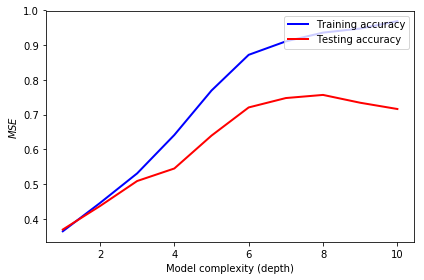

In [46]:
from sklearn.metrics import mean_squared_error

acc_train = []
acc_test = []

for d in range(1, 11):
    regr = DecisionTreeClassifier(max_depth=d, random_state=0)
    regr = regr.fit(X_train, y_train)
    y_train_pred = regr.predict(X_train)
    y_test_pred = regr.predict(X_test)
    
    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_test, y_test_pred))

plt.plot(range(1, 11), acc_train, label = 'Training accuracy', color = 'blue', linewidth = 2)
plt.plot(range(1, 11), acc_test, label = 'Testing accuracy', color = 'red', linewidth = 2)
plt.legend(loc='upper right')
plt.xlabel('Model complexity (depth)')
plt.ylabel('$MSE$')
plt.tight_layout()
plt.show()

# <a name='HM'>Holdout Method</a>
* 把training data分割為互不交集的區域
* 只分成training set和testing set通常會有兩個缺點:
    * 一般我們的資料不多，無法再這樣切割後還有測試的能力和價值
    * 只切割成為一組training set和testing set，一旦我們不幸選擇了不具代表性的那個組合，結果的誤差率計算就沒有估計的意義和價值
* 可以透過cross validation, random subsampling,k-fold cross validation, leave-one-out cross validation和bootstrap解決
---------------------------
* [Reference](https://blog.xuite.net/x5super/studyroom/61471385-%E4%B8%80%E7%AF%87%E5%BE%88%E6%A3%92%E7%9A%84%E6%B8%AC%E8%A9%A6%28%E5%9B%9E%E6%B8%AC%29%E6%8A%80%E8%A1%93%E6%96%87%E7%AB%A0)
* [Back to Holdout Method](#BackHM)

# <a name='Bag'>Bagging</a>
* Bagging 做的事情就是：
<img src='https://lh5.googleusercontent.com/PKbVWxO7aBWahZ70M7W_94RZx8KagvgxzyWjECXl2DPNRayl8VSkgJFhn0T6wZUS51I09HWPb53ElkXm67cULdXEidVj0FtQAbur7iT9hORtNNPqiSNa_adkJu5oFruhqpHCyvU' width='300'></img>
    * 從 N 筆 training data 中，做 sampling 組成 M 個 dataset 每個 dataset 裡面有 N’ 筆資料，使用 sampling 的方法建出很多資料集，訓練出多個 function
<img src='https://lh4.googleusercontent.com/WVWrT_Vh2hA_9CeG-ph6z7GWn5wdkRwmFkltTj9XMCwvfeieGxw-Z2CEMW7fSnk7eQFaZDioBcNbnfvLg0CbukiYOmXBQIB0ifjgfFtMk_UWpsuyBSmBBk5uUic18cNuvXIyA28' width='300'></img>
    * 接著再把我們訓練出來的四個 function 跑出來得結果，拿出來整合，得到最後的結論
        * 如果是 regression 問題，就把 functions output 做平均
        * 如果是 classification 問題，就做 **voting**
---------------------------
* For example:
    * decision tree 是一個非常容易 overfitting 的方法，只要 tree 夠深，一定能夠在 training data 上面做到 100% 的正確率，但是不見得能夠再 testing 時表現得好
    * bagging去解決
<img src='https://lh3.googleusercontent.com/GsAo6bXuJQmuqOMp1c9UvqZvkAaAPl4p7SG81IWQtzrcs-fAy0zDzxLResx71vTD4m1gZHuEaxzD_LdPzv2mXMSrQfPAtipR83HevA0nrXxy3AvGYI3cZNzEQyNxM4lrMAru7YU' width='400'></img>

--------------
* [Reference](http://violin-tao.blogspot.com/2018/01/ml-ensemble.html)
* [Back to Bagging](#BackBagging)

# <a name='Boost'>Boosting</a>
* Bossting 的保證:
    * 假設你有一個 Model 錯誤率高過 50% 只要能夠做到這件事情，boosting 可以把這些錯誤率值略高於 50% 的Model 降到 0%
* 核心想法：
    * 我們找很多個classifier f1,f2,f3, … 如果找到 f2 跟 f1 是互補的，f2 要去做 f1 無法做到的事情，然後再找到 f3 也要跟 f2 互補，這樣一直找一大把後集合起來，就會很強
    * 使用 Boosting 在找 f1, f2, f3 的過程中，是要有順序的，因為每次找的人都要能夠做到上一個人沒辦法辦到的事情
-------
* 怎麼得到不同的 Classifier?
    * re-sampling
        * 製造不同的 traing set
<img src='https://lh3.googleusercontent.com/ZaQSY6bLdnWFYE8cvbrD288Axk61r0vsb1gBSGgpfurqHjYbDfO9xJc4Eh4s2CU3mjpLceyOnPwyCuC6HdbmiMa8E7f4yK-KrQ0G1YeKcFQUBNyccyaqFJHnx6JTVWbX90KNJ-c' width='400'></img>
    * re-weight
        * 假如我們有三筆 data 每一筆 data weight 都給予不一樣的權重，在 training 的時候 loss function 在計算每一筆 error 的時候在前面乘以該筆 data 權重值，使得他在 training 的時候被多考慮一點，或是被多忽略一點
---------------
* For example:
    * Adaboost
    * 想法:
    <img src='https://lh4.googleusercontent.com/NYnP5msJJZ364Tqb6NqWzwG_tYS6K5zxOoja4b985q-3Wop3jkv0DlDl4NGpP6lHg5iKK3Xqq_2IoLqm4L2MOuQA3eXwouRlk-5heOrDk8ggLMgBPVoEXMrM0siT69E9nWzbC_M' width='400'></img>
    * 要找一組新的 training data 使得讓 f1 在新的 data 上面結果會爛掉，正確率會接近 50%，然後再用這組新的 training data 上面來訓練 f2
    * Problem:如何找新的 training data 可讓 f1 壞掉呢？
        * 定義 eslon_1 為 f1 再 training data 上的 error rate，其中 eslon_1 會 < 0.5，我們不可能讓 error 超過 0.5(因為 error rate 大於 0.5 時只要把結果相反來看就好了）
        * 核心想法:
            * 假設原來的 training data weight 是 u1新的 training data weight 是 u2，我們目標是把 u1 換成 u2 ，讓 f1 的 error rate epsilon_1 = 0.5，使得 f1 的表現看起來就像是隨機的一樣
            * 得到 u2 後，拿 u2 作為 weight data 然後拿這樣的 dataset 去訓練 f2，這樣訓練出來的 f2 就會補足 f1 的弱點
-----------
* [Reference](http://violin-tao.blogspot.com/2018/01/ml-ensemble.html)
* [Back to Boosting](#BackBoosting)

# <a name='AdaBoost'>Adaboost</a>
* AdaBoost算法，是一種改進的Boosting分類算法
* 方式是提高被前幾個分類器線性組合的分類**錯誤**樣本的權重，這樣做可以讓每次訓練新的分類器的時後都聚焦在容易分類錯誤的訓練樣本上
* 每個弱分類器使用加權投票機制取代平均投票機制，只的準確率較大的弱分類器有較大的權重，反之，準確率低的弱分類器權重較低
* AdaBoost的手法
    * 讓判斷錯誤的train data提高權重，讓產生新的權重的training set讓舊的分類器f1(x) fail掉，但在新的分類器上就去加強學這些權重較大的training set。
-----------------------
* [Reference](https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ensemble-learning%E4%B9%8Bbagging-boosting%E5%92%8Cadaboost-af031229ebc3)
* [Back to Adaboost](#BackBoosting)

# Bagging與Boosting的區別之處
* 訓練樣本:
    * Bagging: 每一次的訓練集是隨機抽取(每個樣本權重一致)，抽出可放回，以獨立同分布選取的訓練樣本子集訓練弱分類器
    * Boosting: 每一次的訓練集不變，訓練集之間的選擇不是獨立的，每一是選擇的訓練集都是依賴上一次學習得結果，根據錯誤率(給予訓練樣本不同的權重)取樣
* 分類器:
    * Bagging: 每個分類器的權重相等
    * Boosting: 每個弱分類器都有相應的權重，對於分類誤差小的分類器會有更大的權重
* 每個分類器的取得:
    * Bagging: 每個分類器可以並行生成
    * Boosting: 每個弱分類器只能依賴上一次的分類器順序生成
* Bagging和Boosting這兩種方法是比較常見的ensemble learning的方法，當然ensemble learning還有很多不同的方法
-----------------------
* [Reference](https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ensemble-learning%E4%B9%8Bbagging-boosting%E5%92%8Cadaboost-af031229ebc3)